In [1]:
# import jdc
import numpy as np
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import expon
import random
import math

In [3]:

from scipy.stats import expon

numargs = expon.numargs
[ ] = [0.6, ] * numargs
rv = expon( )

print ("RV : \n", rv)


RV : 


In [4]:
from rl_glue import RLGlue
from agent import BaseAgent
from environment import BaseEnvironment  

## Section 1. Environment: the Informed Give-Up Task as an MDP

In [5]:
def isInBounds(HowLongHasTheAgentWaited, MaxTime):
    return (HowLongHasTheAgentWaited >= 0) and (HowLongHasTheAgentWaited < MaxTime)

In [6]:
def FindIndexOfTime(TimeArray, TargetTimestamp): 
    FindIndex = np.where(TimeArray == TargetTimestamp)
    IndexArray = FindIndex[0]
    index = IndexArray[0]
    return index

In [7]:
def pursuit_init(TimeArray, MinDelay, scale): 
        PSRewardTimePDF = expon.pdf(TimeArray, MinDelay, scale)
        PSRewardTimeCDF = expon.cdf(TimeArray, MinDelay, scale)
        return PSRewardTimePDF, PSRewardTimeCDF

def background_init(TimeArray, FixedRewardTime): 
        FixedRewardBin = FindIndexOfTime(TimeArray, FixedRewardTime) 
        BGRewardTimePDF = np.zeros(len(TimeArray))
        BGRewardTimePDF[FixedRewardBin] = 1
        return BGRewardTimePDF

In [8]:
def FindStateStart(TimeArray, TargetTimestamp):
    FindIndex = np.where(TimeArray <= TargetTimestamp)
    IndexArray = FindIndex[0]
    index = max(IndexArray)
    T = TimeArray[index]
    return T

In [9]:
def PrecisionOf(dt):
    import decimal
    d = decimal.Decimal(str(dt))
    DecimalDigit = -d.as_tuple().exponent
    return DecimalDigit

PrecisionOf(0.02)

2

In [10]:
def argmax(array):
        """argmax with random tie-breaking
        Args:
            Numpy array: e.g. the array of action-values
        Returns:
            action (int): e.g. an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(array)):
            if array[i] > top:
                top = array[i]
                ties = []
                ties.append(i)

            if array[i] == top:
                ties.append(i)

        return np.random.choice(ties)

In [10]:
# construct dilating states
def construct_dilating_states(dur, fdt, gamma):
        p = 1 / gamma
        
        if (p == 1): 
            TimeArray = np.round(np.arange(0, dur, fdt), PrecisionOf(fdt))
        else: 
            state_num = 0
            while ((fdt * (1 - p ** (state_num + 1)) / (1 - p)) < dur): 
                state_num += 1
            increments = np.ones(state_num + 1) * fdt
            TimeArray = np.zeros(state_num + 1)
            for ii in range(1, len(increments)): 
                increments[ii] = increments[ii] / (gamma ** (ii))
                TimeArray[ii] = np.round(sum(increments[0:ii]), PrecisionOf(fdt) + 1)
#         if (len(TimeArray) == 1): 
#             last_timestamp = np.round(TimeArray[-1] + fdt, PrecisionOf(fdt) + 1)
#         else:
#             last_timestamp = np.round(TimeArray[-1] + (TimeArray[-1] - TimeArray[-2]) * p, PrecisionOf(fdt) + 1)
        
#         TimeArray = np.append(TimeArray, last_timestamp)
            
        return TimeArray

x = construct_dilating_states(4.8, 0.1, 0.9)
print(x)
print(len(x))

[0.   0.1  0.21 0.33 0.47 0.62 0.79 0.98 1.19 1.42 1.68 1.97 2.29 2.64
 3.03 3.47 3.96 4.5 ]
18


In [11]:
# Unfinished work of programming an informing environment
# Create GiveUpEnvironment class.
# class GiveUpEnvironment(BaseEnvironment):
class InformedGiveUpEnvironment(BaseEnvironment):
    def __init__(self, env_info={}):
        self.current_state4d = np.zeros(3)
        self.current_state1d = 0
        
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """
        # Note, we can setup the following variables later, in env_start() as it is equivalent. 
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]
        
        # reward = None
        # state = None # See Aside
        # termination = None
        # self.reward_state_term = (reward, state, termination)
        # self.state = np.zeros(3) # port{background, pursuit}, reward collected in the current port{0, 1}, time waited in the current port
        self.StateStruct = env_info.get("state representation structure", "regular")
        self.PSRewardAmount = env_info.get("reward amount in pursuit", 1)
        self.BGRewardAmount = env_info.get("reward amount in background", 1)
        
        self.dt = env_info.get("fundamental timestep", 0.1)
        self.gamma = env_info.get("gamma", 0.9)
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        self.PS_dur = env_info.get("pursuit port total duration", 9)
        self.BG_dur = env_info.get("background port total duration", 2)
        self.transit_dur = env_info.get("transit duration", 0.5)
        self.consmp_dur = env_info.get("consumption duration", 1)
        
        # pursuit port: set the default distribution of reward delivery time
        self.PSMinDelay = env_info.get("first time in pursuit port that could give a reward", 1.4)
        self.PSscale = env_info.get("exponential distribution scale", 4.8)
        self.PSMinStay = env_info.get("required minimum wait time in pursuit port", 1.4)
        self.PSResetTime = env_info.get("time to wait until the trial reset", 1.4)
        
        # background port: set the default distribution of reward delivery time
        self.BGRewardTime = env_info.get("delivery time in the background port", 1.5)
        self.BGMinStay = env_info.get("required minimum wait time in background port", 1.4)
        
        if (self.StateStruct == "dilating"): 
            self.BGTimeArray = construct_dilating_states(self.BG_dur, self.dt, self.gamma)
            self.PSTimeArray = construct_dilating_states(self.PS_dur, self.dt, self.gamma)
            self.PSMinDelay = FindStateStart(self.PSTimeArray, self.PSMinDelay)
            self.BGRewardTime = FindStateStart(self.BGTimeArray, self.BGRewardTime)
            self.TravelTimeArray = construct_dilating_states(self.transit_dur, self.dt, self.gamma)
        elif (self.StateStruct == "regular"): 
            self.BGTimeArray = np.round(np.arange(0, self.BG_dur, self.dt), PrecisionOf(self.dt))
            self.PSTimeArray = np.round(np.arange(0, self.PS_dur, self.dt), PrecisionOf(self.dt))
            self.TravelTimeArray = np.round(np.arange(0, self.transit_dur, self.dt), PrecisionOf(self.dt))
        else: 
            raise Exception(str(self.StateStruct) + ' not in recognized state representation structures ["regular", "dilating"]!')
        
        PDFCDF = pursuit_init(self.PSTimeArray, self.PSMinDelay, self.PSscale)
        self.PSRewardTimePDF = PDFCDF[0]
        self.PSRewardTimeCDF = PDFCDF[1]
        self.BGRewardTimePDF = background_init(self.BGTimeArray, self.BGRewardTime)
        
        self.num_states = len(self.BGTimeArray) - FindIndexOfTime(self.BGTimeArray, self.BGRewardTime)\
        + len(self.TravelTimeArray)\
        + 2* (len(self.PSTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)\
              + len(self.TravelTimeArray) + FindIndexOfTime(self.BGTimeArray, self.BGRewardTime))  
        
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """
        # Note, we can setup the following variables later, in env_start() as it is equivalent. 
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]
        
        # reward = None
        # state = None # See Aside
        # termination = None
        # self.reward_state_term = (reward, state, termination)
        # self.state = np.zeros(3) # port{background, pursuit}, reward collected in the current port{0, 1}, time waited in the current port
        self.StateStruct = env_info.get("state representation structure", "regular")
        self.PSRewardAmount = env_info.get("reward amount in pursuit", 1.8)
        self.BGRewardAmount = env_info.get("reward amount in background", [1.2, 2.4])
        
        self.dt = env_info.get("fundamental timestep", 0.1)
        self.gamma = env_info.get("gamma", 0.9)
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        self.PS_dur = env_info.get("pursuit port total duration", 9)
        self.BG_dur = env_info.get("background port total duration", 2)
        self.transit_dur = env_info.get("transit duration", 0.5)
        self.consmp_dur = env_info.get("consumption duration", 1)
        
        # pursuit port: set the default distribution of reward delivery time
        self.PSMinDelay = env_info.get("first time in pursuit port that could give a reward", 1.4)
        self.PSscale = env_info.get("exponential distribution scale", 4.8)
        self.PSMinStay = env_info.get("required minimum wait time in pursuit port", 1.4)
        self.PSResetTime = env_info.get("time to wait until the trial reset", 1.4)
        self.CueTime = env_info.get("cue time", 1.4)
        
        # background port: set the default distribution of reward delivery time
        self.BGRewardTime = env_info.get("delivery time in the background port", 1.5)
        self.BGMinStay = env_info.get("required minimum wait time in background port", 1.4)
        
        if (self.StateStruct == "dilating"): 
            self.BGTimeArray = construct_dilating_states(self.BG_dur, self.dt, self.gamma)
            self.PSTimeArray = construct_dilating_states(self.PS_dur, self.dt, self.gamma)
            self.PSMinDelay = FindStateStart(self.PSTimeArray, self.PSMinDelay)
            self.BGRewardTime = FindStateStart(self.BGTimeArray, self.BGRewardTime)
        elif (self.StateStruct == "regular"): 
            self.BGTimeArray = np.round(np.arange(0, self.BG_dur, self.dt), PrecisionOf(self.dt) + 1)
            self.PSTimeArray = np.round(np.arange(0, self.PS_dur, self.dt), PrecisionOf(self.dt) + 1)
        else: 
            raise Exception(str(self.StateStruct) + ' not in recognized state representation structures ["regular", "dilating"]!')
        
        PDFCDF = pursuit_init(self.PSTimeArray, self.PSMinDelay, self.PSscale)
        self.PSRewardTimePDF = PDFCDF[0]
        self.PSRewardTimeCDF = PDFCDF[1]
        self.BGRewardTimePDF = background_init(self.BGTimeArray, self.BGRewardTime)
        
        self.num_states = len(self.BGTimeArray) + len(self.PSTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)
    
    
    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        reward = 0
        # current state of the agent is a 3-dimensional variable of {WhichPort, HowLongHasTheAgentWaited, RewardCollected}
        self.current_state4d = (0, 0, 0)
        self.current_state1d = self.state1d(self.current_state4d)
        termination = False
        self.reward_state_term = (reward, self.current_state1d, termination)

        return self.reward_state_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent. 
            can be 0: wait, or 1: give up

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """

        self.current_state1d = self.state1d(self.current_state4d)
        P, T, C, Q = self.current_state4d # Port, Time, Collected reward, Cue
        reward = 0 # default reward is 0
        num_rewards = 0 # default number of reward is 0. # The number of rewards has nothing to do with reward amount
        
        # inside the background port
        if (P == 0):
            
            if (action == 0):
            # if stay, port does not change
                
                if isInBounds(T, self.PSTimeArray[-1]):
                # within the maximum duration, will follow the reward function
                    
                    if (C == 0): 
                        # generate a random number between 0 and 1. 
                        # when it falls below Pr{rewarded at t|not rewarded prior to t}, then give a reward, otherwise no reward
                        Pr_NeverRewarded = 1 - self.PSRewardTimeCDF[FindIndexOfTime(self.PSTimeArray, T)]
                        Pr_NeverRewardedNRewardedAtT = self.PSRewardTimePDF[FindIndexOfTime(self.PSTimeArray, T)]
                        Pr_RewardedAtTGivenNotYetRewarded = Pr_NeverRewardedNRewardedAtT / Pr_NeverRewarded
                        rand = self.rand_generator.uniform(low = 0, high = 1, size = 1) 
                        if (rand < Pr_RewardedAtTGivenNotYetRewarded): 
                            reward = self.PSRewardAmount
                            num_rewards = 1
                        else: 
                            pass

                        NextIndex = FindIndexOfTime(self.PSTimeArray, T) + 1
                        T = self.PSTimeArray[NextIndex]

                    elif (C == 1): 
                        # no reward
                        NextIndex = FindIndexOfTime(self.PSTimeArray, T) + 1
                        T = self.PSTimeArray[NextIndex]
                else: 
                    # if agent stays longer than the maximum time, they will be seen as in the same state
                    pass 
                        

                C = C + num_rewards

            # if leave/give up, then jump to the first state in the background port
            elif (action == 1):
                if isInBounds(T, self.PS_dur) and (T >= self.PSMinStay):
                    
                    P, T, C = 2, 0, 0
                elif isInBounds(T, self.PSMinStay): 
                    P, T, C = 0, 0, 0
                else: 
                    pass

            else: 
                raise Exception(str(action) + " not in recognized actions [0: Wait, 1: Give up and leave]!")
            
            
            
            
            
            
            

        # inside the pursuit port
        elif (P == 1): 
            # if stay/wait, then get a reward at a fixed time point
            if (action == 0): 
                # port doe not change
                if isInBounds(T, self.BGTimeArray[-1]):
                    
                    reward = self.BGRewardTimePDF[FindIndexOfTime(self.BGTimeArray, T)] * self.BGRewardAmount[Q]
                    num_rewards = self.BGRewardTimePDF[FindIndexOfTime(self.BGTimeArray, T)] * 1
                    NextIndex = FindIndexOfTime(self.BGTimeArray, T) + 1
                    T = self.BGTimeArray[NextIndex]
                # if agent stays longer than the maximum time, they will be seen as in the same state
                if not isInBounds(T, self.BGTimeArray[-1]): 
                    pass

                C = C + num_rewards

            # if leave/give up, then jump to the first state in the pursuit port
            elif (action == 1): 
                if isInBounds(T, self.BG_dur) and (T >= self.BGMinStay):
                    P, T, C = 3, 0, 0
                elif isInBounds(T, self.BGMinStay): 
                    P, T, C = 1, 0, 0
                else: 
                    pass

            else: 
                raise Exception(str(action) + " not in recognized actions [0: Wait, 1: Give up and leave]!")
        
        # the travel pursuit (from port 0 to port 1)
        elif (P == 2): 
            if isInBounds(T, self.TravelTimeArray[-1]):
                NextIndex = FindIndexOfTime(self.TravelTimeArray, T) + 1
                T = self.TravelTimeArray[NextIndex]
            else: 
                if (action == 0): 
                    pass
                elif (action == 1): 
                    P, T, C = 1, 0, 0
                else: 
                    raise Exception(str(action) + " not in recognized actions [0: Stay, 1: Leave the travel pursuit]!")
            
        # the travel pursuit (from port 1 to port 0)
        elif (P == 3): 
            if isInBounds(T, self.TravelTimeArray[-1]):
                NextIndex = FindIndexOfTime(self.TravelTimeArray, T) + 1
                T = self.TravelTimeArray[NextIndex]
            else: 
                if (action == 0): 
                    pass
                elif (action == 1): 
                    P, T, C = 0, 0, 0
                else: 
                    raise Exception(str(action) + " not in recognized actions [0: Stay, 1: Leave the travel pursuit]!")

        # assign the new state to the environment object
        self.current_state4d = (P, T, C)
        self.current_state1d = self.state1d(self.current_state4d)
        termination = False
        self.reward_state_term = (reward, self.current_state1d, termination)
        return self.reward_state_term


    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        self.current_state4d = (0, 0, 0)
        self.current_state1d = 0
    
    # helper method 
    def state1d(self, state4d):
        P = state4d[0]
        T = state4d[1]
        C = state4d[2]
        if (P == 0):
            if (T <= self.BGRewardTime) and (C == 1): 
                raise Exception(f"It is not possible that a reward is delivered before {self.BGRewardTime}. Hence this state does not exist. ")
            elif (T > self.BGRewardTime) and (C == 0):
                raise Exception(f"It is not possible that no reward is delivered at {self.BGRewardTime}. Hence this state does not exist. ")
            else: 
                return FindIndexOfTime(self.BGTimeArray, T)
        
        elif (P == 1): 
            if (C == 0): 
                return FindIndexOfTime(self.PSTimeArray, T) + len(self.BGTimeArray)
            elif (C == 1): 
                return FindIndexOfTime(self.PSTimeArray, T) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(str(C) + " not in the possible range of number of collected rewards [0, 1]!")
        
        elif (P == 2): 
            if (C == 0): 
                return FindIndexOfTime(self.TravelTimeArray, T) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(f"No reward could be delivered during travel time.")
                
        elif (P == 3): 
            if (C == 0): 
                return FindIndexOfTime(self.TravelTimeArray, T) + len(self.TravelTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(f"No reward could be delivered during travel time.")
        
        else: 
            raise Exception(str(P) + " not in recognized pursuit [0: Background, 1: Pursuit, 2: travel from 0 to 1, 3: travel from 1 to 0]!")
    
    def state4d(self, state1d): 
        s = state1d
        if (s < self.BGTimeArray.shape[0]): 
            P = 0
            T = self.BGTimeArray[s]
            C = 0
            if (T > self.BGRewardTime): 
                C = 1
        elif (s >= self.BGTimeArray.shape[0]) and (s < len(self.PSTimeArray) + len(self.BGTimeArray)):
            P = 1
            T = self.PSTimeArray[s-self.BGTimeArray.shape[0]]
            C = 0
        
        elif (s >= len(self.PSTimeArray) + len(self.BGTimeArray)) and \
        (s < len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
         + len(self.PSTimeArray) + len(self.BGTimeArray)):
            P = 1
            T = self.PSTimeArray[s-len(self.PSTimeArray)-len(self.BGTimeArray)\
                                 +FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)]
            C = 1
        
        elif (s >= len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
              + len(self.PSTimeArray) + len(self.BGTimeArray)) \
        and (s < len(self.TravelTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
             + len(self.PSTimeArray) + len(self.BGTimeArray)): 
            P = 2
            T = self.TravelTimeArray[s-len(self.PSTimeArray)+FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)\
                                       -len(self.PSTimeArray)-len(self.BGTimeArray)]
            C = 0
        
        else: 
            P = 3
            T = self.TravelTimeArray[s-len(self.TravelTimeArray)\
                                     -len(self.PSTimeArray)+FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)\
                                     -len(self.PSTimeArray)-len(self.BGTimeArray)]
            C = 0
        
        
        return (P, T, C)
    
    # function that finds the real optimal policy (that maximizes the global reward rate)
    def PolicyMax(self): 
        PSRewardRate = np.zeros(len(self.PSTimeArray))
        # BGLeaveTime = self.BGRewardTime
        # csmp = self.consmp_dur
        # transit = self.transit_dur
        # BGRewardRate = self.BGRewardAmount / BGLeaveTime
        GlobalRewardRate = np.zeros(len(self.PSTimeArray))
        PS_ExpectedReward = np.zeros(len(self.PSTimeArray))
        PS_ExpectedTime = np.zeros(len(self.PSTimeArray))
        
        for i in range(0, len(self.PSTimeArray)): 
            t = self.PSTimeArray[i]
            if isInBounds(t, self.PSMinStay): 
                t_b = self.BGRewardTime + self.PSResetTime
            else: 
                t_b = self.BGRewardTime
            Pr_RewardedBeforeT = self.PSRewardTimeCDF[i]
            Pr_NotRewardedBeforeT = 1 - Pr_RewardedBeforeT
            PS_ExpectedReward = Pr_RewardedBeforeT * self.PSRewardAmount + Pr_NotRewardedBeforeT * 0
            PS_ExpectedExitTimeIfRewardedBeforeT = np.dot(self.PSTimeArray[0:i], self.PSRewardTimePDF[0:i])
            PS_ExpectedTime = PS_ExpectedExitTimeIfRewardedBeforeT + Pr_NotRewardedBeforeT * t
            Total_ExpectedReward = self.BGRewardAmount + PS_ExpectedReward
            Total_ExpectedTime = t_b + PS_ExpectedTime + self.transit_dur * 2
            PSRewardRate[i] = PS_ExpectedReward / PS_ExpectedTime
            GlobalRewardRate[i] = Total_ExpectedReward / Total_ExpectedTime
        
        optimal_giveup_index_rou_g = argmax(GlobalRewardRate)
        optimal_giveup_time_rou_g = self.PSTimeArray[optimal_giveup_index_rou_g]
        optimal_giveup_index_rou_l = argmax(PSRewardRate)
        optimal_giveup_time_rou_l = self.PSTimeArray[optimal_giveup_index_rou_l]
        return (GlobalRewardRate, PSRewardRate, optimal_giveup_time_rou_g, optimal_giveup_time_rou_l)
    
    def test_reward_function(self): 
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.PSTimeArray, self.PSRewardTimePDF)
        fig, bx = plt.subplots(1, 1)
        bx.plot(self.PSTimeArray, self.PSRewardTimeCDF)
        fig, cx = plt.subplots(1, 1)
        cx.plot(self.BGTimeArray, self.BGRewardTimePDF)

In [12]:
rand_generator = np.random.RandomState(0)
a = rand_generator.uniform(low = 0, high = 1, size = 1) 
b = rand_generator.uniform(low = 0, high = 1, size = 1)
print(a, b)

[0.5488135] [0.71518937]


In [13]:
# Create GiveUpEnvironment class.
# class GiveUpEnvironment(BaseEnvironment):
class GiveUpEnvironment(BaseEnvironment):
    def __init__(self, env_info={}):
        self.current_state3d = np.zeros(3)
        self.current_state1d = 0
        
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """
        # Note, we can setup the following variables later, in env_start() as it is equivalent. 
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]
        
        # reward = None
        # state = None # See Aside
        # termination = None
        # self.reward_state_term = (reward, state, termination)
        # self.state = np.zeros(3) # port{background, pursuit}, reward collected in the current port{0, 1}, time waited in the current port
        self.StateStruct = env_info.get("state representation structure", "regular")
        self.PSRewardAmount = env_info.get("reward amount in pursuit", 1)
        self.BGRewardAmount = env_info.get("reward amount in background", [0.3, 0.9])
        
        self.dt = env_info.get("fundamental timestep", 0.1)
        self.gamma = env_info.get("gamma", 0.9)
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        self.PS_dur = env_info.get("pursuit port total duration", 9)
        self.BG_dur = env_info.get("background port total duration", 2)
        self.transit_dur = env_info.get("transit duration", 0.5)
        self.consmp_dur = env_info.get("consumption duration", 1)
        
        # pursuit port: set the default distribution of reward delivery time
        self.PSMinDelay = env_info.get("first time in pursuit port that could give a reward", 1.4)
        self.PSscale = env_info.get("exponential distribution scale", 4.8)
        self.PSMinStay = env_info.get("required minimum wait time in pursuit port", 1.4)
        self.PSResetTime = env_info.get("time to wait until the trial reset", 1.4)
        
        # background port: set the default distribution of reward delivery time
        self.BGRewardTime = env_info.get("delivery time in the background port", 1.5)
        self.BGMinStay = env_info.get("required minimum wait time in background port", 1.4)
        
        if (self.StateStruct == "dilating"): 
            self.BGTimeArray = construct_dilating_states(self.BG_dur, self.dt, self.gamma)
            self.PSTimeArray = construct_dilating_states(self.PS_dur, self.dt, self.gamma)
            self.PSMinDelay = FindStateStart(self.PSTimeArray, self.PSMinDelay)
            self.BGRewardTime = FindStateStart(self.BGTimeArray, self.BGRewardTime)
            self.TravelTimeArray = construct_dilating_states(self.transit_dur, self.dt, self.gamma)
        elif (self.StateStruct == "regular"): 
            self.BGTimeArray = np.round(np.arange(0, self.BG_dur, self.dt), PrecisionOf(self.dt))
            self.PSTimeArray = np.round(np.arange(0, self.PS_dur, self.dt), PrecisionOf(self.dt))
            self.TravelTimeArray = np.round(np.arange(0, self.transit_dur, self.dt), PrecisionOf(self.dt))
        else: 
            raise Exception(str(self.StateStruct) + ' not in recognized state representation structures ["regular", "dilating"]!')
        
        PDFCDF = pursuit_init(self.PSTimeArray, self.PSMinDelay, self.PSscale)
        self.PSRewardTimePDF = PDFCDF[0]
        self.PSRewardTimeCDF = PDFCDF[1]
        self.BGRewardTimePDF = background_init(self.BGTimeArray, self.BGRewardTime)
        
        self.num_states = len(self.BGTimeArray) + len(self.PSTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.TravelTimeArray) * 2
        
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """
        # Note, we can setup the following variables later, in env_start() as it is equivalent. 
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]
        
        # reward = None
        # state = None # See Aside
        # termination = None
        # self.reward_state_term = (reward, state, termination)
        # self.state = np.zeros(3) # port{background, pursuit}, reward collected in the current port{0, 1}, time waited in the current port
        self.StateStruct = env_info.get("state representation structure", "regular")
        self.PSRewardAmount = env_info.get("reward amount in pursuit", 1)
        self.BGRewardAmount = env_info.get("reward amount in background", 1)
        
        self.dt = env_info.get("fundamental timestep", 0.1)
        self.gamma = env_info.get("gamma", 0.9)
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        self.PS_dur = env_info.get("pursuit port total duration", 9)
        self.BG_dur = env_info.get("background port total duration", 2)
        self.transit_dur = env_info.get("transit duration", 0.5)
        self.consmp_dur = env_info.get("consumption duration", 1)
        
        # pursuit port: set the default distribution of reward delivery time
        self.PSMinDelay = env_info.get("first time in pursuit port that could give a reward", 1.4)
        self.PSscale = env_info.get("exponential distribution scale", 4.8)
        self.PSMinStay = env_info.get("required minimum wait time in pursuit port", 1.4)
        self.PSResetTime = env_info.get("time to wait until the trial reset", 1.4)
        
        # background port: set the default distribution of reward delivery time
        self.BGRewardTime = env_info.get("delivery time in the background port", 1.5)
        self.BGMinStay = env_info.get("required minimum wait time in background port", 1.4)
        
        if (self.StateStruct == "dilating"): 
            self.BGTimeArray = construct_dilating_states(self.BG_dur, self.dt, self.gamma)
            self.PSTimeArray = construct_dilating_states(self.PS_dur, self.dt, self.gamma)
            self.PSMinDelay = FindStateStart(self.PSTimeArray, self.PSMinDelay)
            self.BGRewardTime = FindStateStart(self.BGTimeArray, self.BGRewardTime)
        elif (self.StateStruct == "regular"): 
            self.BGTimeArray = np.round(np.arange(0, self.BG_dur, self.dt), PrecisionOf(self.dt) + 1)
            self.PSTimeArray = np.round(np.arange(0, self.PS_dur, self.dt), PrecisionOf(self.dt) + 1)
        else: 
            raise Exception(str(self.StateStruct) + ' not in recognized state representation structures ["regular", "dilating"]!')
        
        PDFCDF = pursuit_init(self.PSTimeArray, self.PSMinDelay, self.PSscale)
        self.PSRewardTimePDF = PDFCDF[0]
        self.PSRewardTimeCDF = PDFCDF[1]
        self.BGRewardTimePDF = background_init(self.BGTimeArray, self.BGRewardTime)
        
        self.num_states = len(self.BGTimeArray) + len(self.PSTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)
    
    
    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        reward = 0
        # current state of the agent is a 3-dimensional variable of {WhichPort, HowLongHasTheAgentWaited, RewardCollected}
        self.current_state3d = (0, 0, 0)
        self.current_state1d = self.state1d(self.current_state3d)
        termination = False
        self.reward_state_term = (reward, self.current_state1d, termination)

        return self.reward_state_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent. 
            can be 0: wait, or 1: give up

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """

        self.current_state1d = self.state1d(self.current_state3d)
        P, T, C = self.current_state3d # Port, Time, Collected reward
        reward = 0 # default reward is 0
        num_rewards = 0 # default number of reward is 0. # The number of rewards has nothing to do with reward amount
        
        # inside the background port
        if (P == 0):

            # if stay/wait, then get a reward at a fixed time point
            if (action == 0): 
                # port doe not change
                if isInBounds(T, self.BGTimeArray[-1]):
                    amount_rand = self.rand_generator.uniform(low = 0, high = 1, size = 1)
                    if (amount_rand < 0.5):
                        reward = self.BGRewardTimePDF[FindIndexOfTime(self.BGTimeArray, T)] * self.BGRewardAmount[0]
                    else: 
                        reward = self.BGRewardTimePDF[FindIndexOfTime(self.BGTimeArray, T)] * self.BGRewardAmount[1]
                    num_rewards = self.BGRewardTimePDF[FindIndexOfTime(self.BGTimeArray, T)] * 1
                    NextIndex = FindIndexOfTime(self.BGTimeArray, T) + 1
                    T = self.BGTimeArray[NextIndex]
                # if agent stays longer than the maximum time, they will be seen as in the same state
                if not isInBounds(T, self.BGTimeArray[-1]): 
                    pass

                C = C + num_rewards

            # if leave/give up, then jump to the first state in the pursuit port
            elif (action == 1): 
                if isInBounds(T, self.BG_dur) and (T >= self.BGMinStay):
                    P, T, C = 2, 0, 0
                elif isInBounds(T, self.BGMinStay): 
                    P, T, C = 0, 0, 0
                else: 
                    pass

            else: 
                raise Exception(str(action) + " not in recognized actions [0: Wait, 1: Give up and leave]!")

        # inside the pursuit port
        elif (P == 1): 
            if (action == 0):
            # if stay, port does not change
                
                if isInBounds(T, self.PSTimeArray[-1]):
                # within the maximum duration, will follow the reward function
                    
                    if (C == 0): 
                        # generate a random number between 0 and 1. 
                        # when it falls below Pr{rewarded at t|not rewarded prior to t}, then give a reward, otherwise no reward
                        Pr_NeverRewarded = 1 - self.PSRewardTimeCDF[FindIndexOfTime(self.PSTimeArray, T)]
                        Pr_NeverRewardedNRewardedAtT = self.PSRewardTimePDF[FindIndexOfTime(self.PSTimeArray, T)]
                        Pr_RewardedAtTGivenNotYetRewarded = Pr_NeverRewardedNRewardedAtT / Pr_NeverRewarded
                        rand = self.rand_generator.uniform(low = 0, high = 1, size = 1) 
                        if (rand < Pr_RewardedAtTGivenNotYetRewarded): 
                            reward = self.PSRewardAmount
                            num_rewards = 1
                        else: 
                            pass

                        NextIndex = FindIndexOfTime(self.PSTimeArray, T) + 1
                        T = self.PSTimeArray[NextIndex]

                    elif (C == 1): 
                        # no reward
                        NextIndex = FindIndexOfTime(self.PSTimeArray, T) + 1
                        T = self.PSTimeArray[NextIndex]
                else: 
                    # if agent stays longer than the maximum time, they will be seen as in the same state
                    pass 
                        

                C = C + num_rewards

            # if leave/give up, then jump to the first state in the background port
            elif (action == 1):
                if isInBounds(T, self.PS_dur) and (T >= self.PSMinStay):
                    P, T, C = 3, 0, 0
                elif isInBounds(T, self.PSMinStay): 
                    P, T, C = 1, 0, 0
                else: 
                    pass

            else: 
                raise Exception(str(action) + " not in recognized actions [0: Wait, 1: Give up and leave]!")
        
        # the travel pursuit (from port 0 to port 1)
        elif (P == 2): 
            if isInBounds(T, self.TravelTimeArray[-1]):
                NextIndex = FindIndexOfTime(self.TravelTimeArray, T) + 1
                T = self.TravelTimeArray[NextIndex]
            else: 
                if (action == 0): 
                    pass
                elif (action == 1): 
                    P, T, C = 1, 0, 0
                else: 
                    raise Exception(str(action) + " not in recognized actions [0: Stay, 1: Leave the travel pursuit]!")
            
        # the travel pursuit (from port 1 to port 0)
        elif (P == 3): 
            if isInBounds(T, self.TravelTimeArray[-1]):
                NextIndex = FindIndexOfTime(self.TravelTimeArray, T) + 1
                T = self.TravelTimeArray[NextIndex]
            else: 
                if (action == 0): 
                    pass
                elif (action == 1): 
                    P, T, C = 0, 0, 0
                else: 
                    raise Exception(str(action) + " not in recognized actions [0: Stay, 1: Leave the travel pursuit]!")

        # assign the new state to the environment object
        self.current_state3d = (P, T, C)
        self.current_state1d = self.state1d(self.current_state3d)
        termination = False
        self.reward_state_term = (reward, self.current_state1d, termination)
        return self.reward_state_term


    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        self.current_state3d = (0, 0, 0)
        self.current_state1d = 0
    
    # helper method 
    def state1d(self, state3d):
        P = state3d[0]
        T = state3d[1]
        C = state3d[2]
        if (P == 0):
            if (T <= self.BGRewardTime) and (C == 1): 
                raise Exception(f"It is not possible that a reward is delivered before {self.BGRewardTime}. Hence this state does not exist. ")
            elif (T > self.BGRewardTime) and (C == 0):
                raise Exception(f"It is not possible that no reward is delivered at {self.BGRewardTime}. Hence this state does not exist. ")
            else: 
                return FindIndexOfTime(self.BGTimeArray, T)
        
        elif (P == 1): 
            if (C == 0): 
                return FindIndexOfTime(self.PSTimeArray, T) + len(self.BGTimeArray)
            elif (C == 1): 
                return FindIndexOfTime(self.PSTimeArray, T) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(str(C) + " not in the possible range of number of collected rewards [0, 1]!")
        
        elif (P == 2): 
            if (C == 0): 
                return FindIndexOfTime(self.TravelTimeArray, T) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(f"No reward could be delivered during travel time.")
                
        elif (P == 3): 
            if (C == 0): 
                return FindIndexOfTime(self.TravelTimeArray, T) + len(self.TravelTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) + len(self.PSTimeArray) + len(self.BGTimeArray)
            else: 
                raise Exception(f"No reward could be delivered during travel time.")
        
        else: 
            raise Exception(str(P) + " not in recognized pursuit [0: Background, 1: Pursuit, 2: travel from 0 to 1, 3: travel from 1 to 0]!")
    
    def state3d(self, state1d): 
        s = state1d
        if (s < self.BGTimeArray.shape[0]): 
            P = 0
            T = self.BGTimeArray[s]
            C = 0
            if (T > self.BGRewardTime): 
                C = 1
        elif (s >= self.BGTimeArray.shape[0]) and (s < len(self.PSTimeArray) + len(self.BGTimeArray)):
            P = 1
            T = self.PSTimeArray[s-self.BGTimeArray.shape[0]]
            C = 0
        
        elif (s >= len(self.PSTimeArray) + len(self.BGTimeArray)) and \
        (s < len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
         + len(self.PSTimeArray) + len(self.BGTimeArray)):
            P = 1
            T = self.PSTimeArray[s-len(self.PSTimeArray)-len(self.BGTimeArray)\
                                 +FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)]
            C = 1
        
        elif (s >= len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
              + len(self.PSTimeArray) + len(self.BGTimeArray)) \
        and (s < len(self.TravelTimeArray) + len(self.PSTimeArray) - FindIndexOfTime(self.PSTimeArray, self.PSMinDelay) \
             + len(self.PSTimeArray) + len(self.BGTimeArray)): 
            P = 2
            T = self.TravelTimeArray[s-len(self.PSTimeArray)+FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)\
                                       -len(self.PSTimeArray)-len(self.BGTimeArray)]
            C = 0
        
        else: 
            P = 3
            T = self.TravelTimeArray[s-len(self.TravelTimeArray)\
                                     -len(self.PSTimeArray)+FindIndexOfTime(self.PSTimeArray, self.PSMinDelay)\
                                     -len(self.PSTimeArray)-len(self.BGTimeArray)]
            C = 0
        
        
        return (P, T, C)
    
    # function that finds the real optimal policy (that maximizes the global reward rate)
    def PolicyMax(self): 
        PSRewardRate = np.zeros(len(self.PSTimeArray))
        # BGLeaveTime = self.BGRewardTime
        # csmp = self.consmp_dur
        # transit = self.transit_dur
        # BGRewardRate = self.BGRewardAmount / BGLeaveTime
        GlobalRewardRate = np.zeros(len(self.PSTimeArray))
        PS_ExpectedReward = np.zeros(len(self.PSTimeArray))
        PS_ExpectedTime = np.zeros(len(self.PSTimeArray))
        
        for i in range(0, len(self.PSTimeArray)): 
            t = self.PSTimeArray[i]
            if isInBounds(t, self.PSMinStay): 
                t_b = self.BGRewardTime + self.PSResetTime
            else: 
                t_b = self.BGRewardTime
            Pr_RewardedBeforeT = self.PSRewardTimeCDF[i]
            Pr_NotRewardedBeforeT = 1 - Pr_RewardedBeforeT
            PS_ExpectedReward = Pr_RewardedBeforeT * self.PSRewardAmount + Pr_NotRewardedBeforeT * 0
            PS_ExpectedExitTimeIfRewardedBeforeT = np.dot(self.PSTimeArray[0:i], self.PSRewardTimePDF[0:i])
            PS_ExpectedTime = PS_ExpectedExitTimeIfRewardedBeforeT + Pr_NotRewardedBeforeT * t
            Total_ExpectedReward = np.mean(self.BGRewardAmount) + PS_ExpectedReward
            Total_ExpectedTime = t_b + PS_ExpectedTime + self.transit_dur * 2
            PSRewardRate[i] = PS_ExpectedReward / PS_ExpectedTime
            GlobalRewardRate[i] = Total_ExpectedReward / Total_ExpectedTime
        
        optimal_giveup_index_rou_g = argmax(GlobalRewardRate)
        optimal_giveup_time_rou_g = self.PSTimeArray[optimal_giveup_index_rou_g]
        optimal_giveup_index_rou_l = argmax(PSRewardRate)
        optimal_giveup_time_rou_l = self.PSTimeArray[optimal_giveup_index_rou_l]
        return (GlobalRewardRate, PSRewardRate, optimal_giveup_time_rou_g, optimal_giveup_time_rou_l)
    
    def test_reward_function(self): 
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.PSTimeArray, self.PSRewardTimePDF)
        fig, bx = plt.subplots(1, 1)
        bx.plot(self.PSTimeArray, self.PSRewardTimeCDF)
        fig, cx = plt.subplots(1, 1)
        cx.plot(self.BGTimeArray, self.BGRewardTimePDF)

In [14]:

env_info = {"fundamental timestep": 0.1, 
            "gamma": 0.9, 
            "state representation structure": "dilating", 
            "pursuit port total duration": 7, 
            "background port total duration": 9, 
            "transit duration": 0.5, 
            "consumption duration": 1, 
            "first time in pursuit port that could give a reward": 1,
            "required minimum wait time in pursuit port": 1, 
            "time to wait until the trial reset": 1.5, 
            "exponential distribution scale": 4, 
            "delivery time in the background port": 5,
            "reward amount in pursuit": 3, 
            "reward amount in background": [0.9, 1.5], 
            "seed": 0}

env = GiveUpEnvironment(env_info = env_info)
print(len(env.PSTimeArray))
print(len(env.BGTimeArray))
print(env.PSTimeArray)
print(env.BGTimeArray)
print(env.TravelTimeArray)


21
23
[0.   0.1  0.21 0.33 0.47 0.62 0.79 0.98 1.19 1.42 1.68 1.97 2.29 2.64
 3.03 3.47 3.96 4.5  5.1  5.76 6.5 ]
[0.   0.1  0.21 0.33 0.47 0.62 0.79 0.98 1.19 1.42 1.68 1.97 2.29 2.64
 3.03 3.47 3.96 4.5  5.1  5.76 6.5  7.33 8.24]
[0.   0.1  0.21 0.33 0.47]


C:\Users\shich\Anaconda3\lib\site-packages\ipykernel_launcher.py:372: RuntimeWarning: invalid value encountered in double_scalars


According to the global reward rate, the optimal give-up time in the pursuit port is at 3.0 second!
According to the local reward rate, the optimal give-up time in the pursuit port is at 2.1 second!


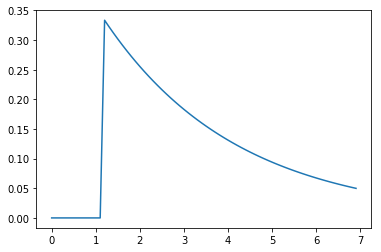

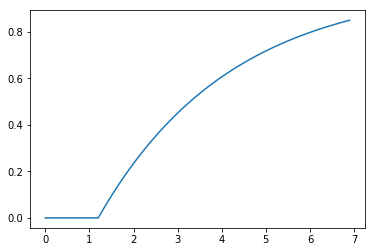

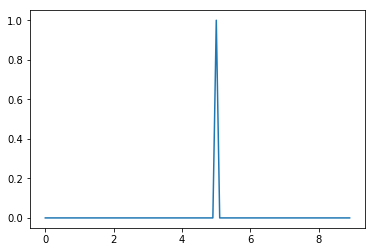

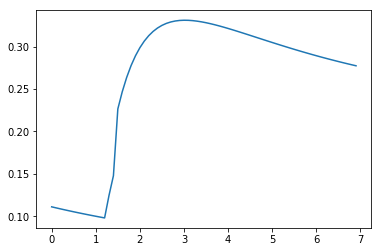

In [29]:
# ---------------
# Debugging Cell
# Plot the reward structures of both ports
# Plot the global reward rate for every policy (policy is represented by its exit time)
# ---------------
env = GiveUpEnvironment()
env.env_init({"state representation structure": "regular", 
              "fundamental timestep": 0.1, 
              "gamma": 0.9, 
              "pursuit port total duration": 7, 
              "background port total duration": 9, 
              "transit duration": 0.5, 
              "consumption duration": 1, 
              "first time in pursuit port that could give a reward": 1.2,
              "required minimum wait time in pursuit port": 1.5, 
              "time to wait until the trial reset": 3, 
              "exponential distribution scale": 3, 
              "delivery time in the background port": 5,
              "reward amount in pursuit": 10, 
              "reward amount in background": [0.8, 1.2], 
              "seed": 0})
env.test_reward_function()
(rou_g, rou_l, t_rou_g, t_rou_l) = env.PolicyMax()
hazard_function = np.zeros(len(env.PSTimeArray))
for i in range(len(env.PSTimeArray)): 
    Pr_NeverRewarded = 1 - env.PSRewardTimeCDF[i]
    Pr_NeverRewardedNRewardedAtT = env.PSRewardTimePDF[i]
    Pr_RewardedAtTGivenNotYetRewarded = Pr_NeverRewardedNRewardedAtT / Pr_NeverRewarded
    hazard_function[i] = Pr_RewardedAtTGivenNotYetRewarded
fig, ax = plt.subplots(1, 1)
ax.plot(env.PSTimeArray, rou_g)
#ax.plot(env.PSTimeArray, rou_l)
print(f"According to the global reward rate, the optimal give-up time in the pursuit port is at {t_rou_g} second!")
print(f"According to the local reward rate, the optimal give-up time in the pursuit port is at {t_rou_l} second!")

In [16]:
# ---------------
# Debugging Cell
# Test if the action at a certain state leads to a certain other state and reward
# ---------------
def test_action():
    env = GiveUpEnvironment()
    env.env_init({"state representation structure": "dilating", 
              "dt": 0.1, 
              "gamma": 0.9, 
              "pursuit port total duration": 7, 
              "background port total duration": 9, 
              "transit duration": 0.5, 
              "consumption duration": 1, 
              "first time in pursuit port that could give a reward": 1,
              "required minimum wait time in pursuit port": 1, 
              "time to wait until the trial reset": 1.5, 
              "exponential distribution scale": 4, 
              "delivery time in the background port": 5,
              "reward amount in pursuit": 3, 
              "reward amount in background": [0.6, 1.8], 
              "seed": 0})
    env.current_state3d = (0, 4.5, 0)
    env.env_step(0)
    print(env.current_state3d)
    print(env.current_state1d)
    # assert(env.current_state == (0, env.dt, 0))
    
    env.current_state3d = (0, 2.29, 0)
    env.env_step(1)
    print(env.current_state3d)
    print(env.current_state1d)
    # assert(env.current_state == (0, 2, 0))
    
    env.current_state3d = (0, 1.19, 0)
    env.env_step(1)
    print(env.current_state3d)
    print(env.current_state1d)
    # assert(env.current_state == (1, 0, 0))
    
def test_reward():
    env = GiveUpEnvironment()
    env.env_init({"state representation structure": "dilating", 
                  "dt": 0.1, 
                  "gamma": 0.9, 
                  "pursuit port total duration": 7, 
                  "background port total duration": 9, 
                  "transit duration": 0.5, 
                  "consumption duration": 1, 
                  "first time in pursuit port that could give a reward": 1,
                  "required minimum wait time in pursuit port": 1, 
                  "time to wait until the trial reset": 1.5, 
                  "exponential distribution scale": 4, 
                  "delivery time in the background port": 5,
                  "reward amount in pursuit": 3, 
                  "reward amount in background": 1, 
                  "seed": 0})
    env.current_state3d = (0, 4.5, 0)
    reward_state_term = env.env_step(1)
    print(env.current_state3d)
    print(reward_state_term[0], reward_state_term[1], reward_state_term[2])
    # assert(reward_state_term[0] == 0 and reward_state_term[1] == (0, env.dt, 0) and reward_state_term[2] == False)
    
    env.current_state3d = (1, 5.76, 0)
    reward_state_term = env.env_step(0)
    print(env.current_state3d)
    print(reward_state_term[0], reward_state_term[1], reward_state_term[2])
    reward_state_term = env.env_step(0)
    print(env.current_state3d)
    print(reward_state_term[0], reward_state_term[1], reward_state_term[2])
    # assert(reward_state_term[0] ==  and reward_state_term[1] ==  and reward_state_term[2] == False)
    
    env.current_state3d = (1, 2.29, 1)
    reward_state_term = env.env_step(1)
    print(env.current_state3d)
    print(reward_state_term[0], reward_state_term[1], reward_state_term[2])
    # assert(reward_state_term[0] == 0 and reward_state_term[1] == (0, 0, 0) and reward_state_term[2] == False)
    
test_action()
test_reward()


(0, 5.1, 1.0)
18
(2, 0, 0)
58
(0, 0, 0)
0
(2, 0, 0)
0 58 False
(1, 6.5, 0)
0 43 False
(1, 6.5, 0)
0 43 False
(3, 0, 0)
0 63 False


## Section 2. Agent

In [17]:
# create BasicTDAgent class
class BasicTDAgent(BaseAgent):
    
    # ---------------
    # As we did with the environment, we first initialize the agent once when a TDAgent object is created. 
    # In this function, we create a random number generator, seeded with 
    # the seed provided in the agent_info dictionary to get reproducible results. 
    # We also set the policy, discount and step size based on the agent_info dictionary. 
    # Finally, with a convention that the policy is always specified as a mapping 
    # from states to actions and so is an array of size (# States, # Actions), 
    # we initialize a values array of shape (# States,) to zeros.
    # ---------------
    def __init__(self, agent_info={}):
            
        """Setup for the agent called when the experiment first starts."""

        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
        self.policy = agent_info.get("policy")
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount")
        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size")

        # Initialize an array of zeros that will hold the values.
        # Recall that the policy can be represented as a (# States, # Actions) array. With the 
        # assumption that this is the case, we can use the first dimension of the policy to
        # initialize the array for values.
        self.values = np.zeros((self.policy.shape[0],))
        self.delta = 0
        
    def agent_init(self, agent_info={}):
    
        """Setup for the agent called when the experiment first starts."""

        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
        self.policy = agent_info.get("policy")
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount")
        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size")

        # Initialize an array of zeros that will hold the values.
        # Recall that the policy can be represented as a (# States, # Actions) array. With the 
        # assumption that this is the case, we can use the first dimension of the policy to
        # initialize the array for values.
        self.values = np.zeros((self.policy.shape[0],))
        
    # ---------------
    # In agent_start(), we choose an action based on the initial state and policy we are evaluating. 
    # We also cache the state so that we can later update its value when we perform a Temporal Difference update. 
    # Finally, we return the action chosen so that the RL loop can continue and the environment can execute this action.
    # ---------------
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """
        # The policy can be represented as a (# States, # Actions) array. So, we can use 
        # the second dimension here when choosing an action.
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        self.last_state = state
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step after the last action, i.e., where the agent ended up after the
                last action
        Returns:
            The action the agent is taking.
        """

        # Hint: We should perform an update with the last state given that we now have the reward and
        # next state. We break this into two steps. Recall for example that the Monte-Carlo update 
        # had the form: V[S_t] = V[S_t] + alpha * (target - V[S_t]), where the target was the return, G_t.

        # your code here
        alpha = self.step_size
        gamma = self.discount
        s = self.last_state
        self.values[s] = self.values[s] + alpha * (reward + gamma * self.values[state] - self.values[s])
        self.delta = reward + gamma * self.values[state] - self.values[s]

        # Having updated the value for the last state, we now act based on the current 
        # state, and set the last state to be current one as we will next be making an 
        # update with it when agent_step is called next once the action we return from this function 
        # is executed in the environment.

        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        self.last_state = state

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

        # Hint: Here too, we should perform an update with the last state given that we now have the 
        # reward. Note that in this case, the action led to termination. Once more, we break this into 
        # two steps, computing the target and the update itself that uses the target and the 
        # current value estimate for the state whose value we are updating.

        # your code here
        alpha = self.step_size
        gamma = self.discount
        s = self.last_state
        self.values[s] = self.values[s] + alpha * (reward - self.values[s])

    def agent_cleanup(self):        
        """Cleanup done after the agent ends."""
        self.last_state = None
        
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        if message == "get_values":
            return self.values
        elif message == "get TD error": 
            return self.delta
        else:
            raise Exception("TDAgent.agent_message(): Message not understood!")

In [18]:
# --------------
# Debugging Cell
# --------------
# The following test checks that the TD check works for a case where the transition 
# garners reward -1 and does not lead to a terminal state. This is in a simple two state setting 
# where there is only one action. The first state's current value estimate is 0 while the second is 1.
# Note the discount and step size if you are debugging this test.
policy_list = np.array([[1.], [1.]])
agent_info = {"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1}
agent = BasicTDAgent(agent_info = agent_info)

agent.values = np.array([0., 1.])
agent.agent_start(0)

reward = -1
next_state = 1
agent.agent_step(reward, next_state)

assert(np.isclose(agent.values[0], -0.001) and np.isclose(agent.values[1], 1.))

# The following test checks that the TD check works for a case where the transition 
# garners reward -100 and lead to a terminal state. This is in a simple one state setting 
# where there is only one action. The state's current value estimate is 0.
# Note the discount and step size if you are debugging this test.
policy_list = np.array([[1.]])
agent_info = {"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1}
agent = BasicTDAgent(agent_info = agent_info)

agent.values = np.array([0.])
agent.agent_start(0)

reward = -100
next_state = 0
agent.agent_end(reward)

assert(np.isclose(agent.values[0], -10))

In [19]:
class QLearningAgent(BaseAgent):
    def __init__(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_info["num_actions"]
        self.num_states = agent_info["num_states"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        self.c = agent_info.get("degree of exploration", 0.2)
        self.exploration_method = agent_info.get("exploration method", "UCB")
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = 0.5 * np.ones((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.delta = 0
        self.total_steps = 0
        self.SAcounter = np.zeros((self.num_states, self.num_actions)) # The array of times each state-action pair is chosen.
        self.UCB = math.inf * np.ones((self.num_states, self.num_actions)) # The array of upper-confidence-bounds for each state-action pair. 
        
    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_info.
        self.num_actions = agent_info["num_actions"]
        self.num_states = agent_info["num_states"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        self.c = agent_info.get("degree of exploration", 0.2)
        self.exploration_method = agent_info.get("exploration method", "UCB")
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = 0.5 * np.ones((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.delta = 0
        self.total_steps = 0
        self.SAcounter = np.zeros((self.num_states, self.num_actions)) # The array of times each state-action pair is chosen.
                     
    def agent_start(self, observation):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        state = observation
        current_q = self.q[state, :]
        
        if (self.exploration_method == "epsilon-greedy"):
            # Choose action using epsilon greedy.
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)
        elif (self.exploration_method == "UCB"):
            # Choose action using Upper-Confidence-Bound. 
            action = self.argmax(self.UCB[state])
        else: 
            raise Exception(self.exploration_method + " not in recognized exploration methods: 'epsilon-greedy' or 'UCB'!")
        
        self.update_UCB(state)
        self.total_steps += 1
        self.SAcounter[state, action] += 1
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        state = observation
        current_q = self.q[state, :]
        
        if (self.exploration_method == "epsilon-greedy"):
            # Choose action using epsilon greedy.
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(self.num_actions)
            else:
                action = self.argmax(current_q)
        elif (self.exploration_method == "UCB"):
            # Choose action using Upper-Confidence-Bound. 
            action = self.argmax(self.UCB[state])
        else: 
            raise Exception(self.exploration_method + " not in recognized exploration methods: 'epsilon-greedy' or 'UCB'!")
        
        # Perform an update
        # --------------------------
        # your code here
        alpha = self.step_size
        gamma = self.discount
        r = reward
        MaxQSpa = max(current_q) # meaning max(Q(S', a))
        QSA = self.q[self.prev_state, self.prev_action] # meaning Q(S, A)
        self.q[self.prev_state, self.prev_action] = QSA + alpha * (r + gamma * MaxQSpa - QSA)
        self.delta = r + gamma * MaxQSpa - QSA
        # --------------------------
        
        self.update_UCB(state)
        self.total_steps += 1
        self.SAcounter[state, action] += 1
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        # --------------------------
        # your code here
        alpha = self.step_size
        gamma = self.discount
        r = reward
        QSA = self.q[self.prev_state, self.prev_action] # meaning Q(S, A)
        self.q[self.prev_state, self.prev_action] = QSA + alpha * (r - QSA)
        # --------------------------
    
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        if message == "get_action_values":
            return self.q
        elif message == "get TD error": 
            return self.delta
        else:
            raise Exception("TDAgent.agent_message(): Message not understood!")
    
    def update_UCB(self, state): 
        """The method gets the current upper confidence bound of each 
        action at a certain state. 
        Args: 
            state (int): the state of which the UCBs of actions are needed.
            
        Returns: 
            UCB (array): the upper confidence bound of each action
            at a certain state.
        """
        for j in range(self.num_actions): 
            if (self.SAcounter[state][j] == 0):
                self.UCB[state][j] = math.inf
            else: 
                self.UCB[state][j] = self.q[state][j] + self.c * math.sqrt(np.log(self.total_steps) / self.SAcounter[state][j])
                self.UCB[state][j] = np.round(self.UCB[state][j], 1)
        
        return self.UCB
    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Section 4. Simulating Learning Process with Q-learning and SARSA

Finally, see the TD policy evaluation algorithm in action by looking at the estimated values, the per state value error and after the experiment is complete, the Mean Squared Value Error curve vs. episode number, summarizing how the value error changed over time.

The code below runs one run of an experiment given env_info and agent_info dictionaries. 

C:\Users\shich\Anaconda3\lib\site-packages\ipykernel_launcher.py:372: RuntimeWarning: invalid value encountered in double_scalars


According to the global reward rate, the optimal give-up time in the pursuit port is at 2.0 second!
According to the local reward rate, the optimal give-up time in the pursuit port is at 2.8 second!


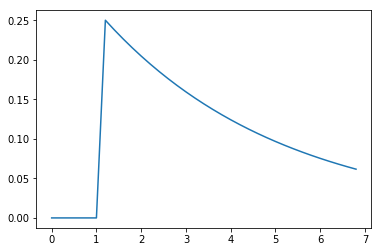

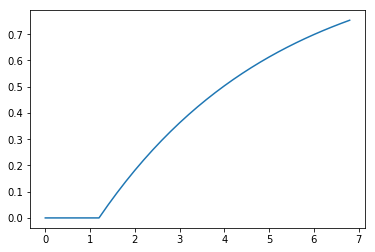

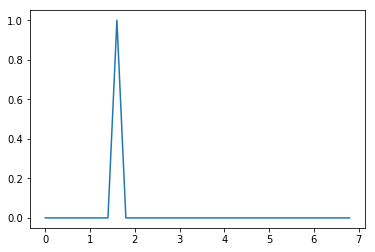

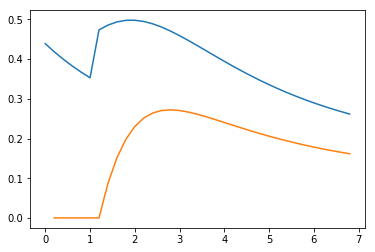

In [20]:
env_info = {"state representation structure": "regular", 
            "fundamental timestep": 0.2, 
            "gamma": 0.9, 
            "pursuit port total duration": 7, 
            "background port total duration": 7, 
            "transit duration": 0.5, 
            "consumption duration": 1, 
            "first time in pursuit port that could give a reward": 1.2,
            "required minimum wait time in pursuit port": 1.2, 
            "required minimum wait time in background port": 1, 
            "time to wait until the trial reset": 1.5, 
            "exponential distribution scale": 4, 
            "delivery time in the background port": 1.6,
            "reward amount in pursuit": 2.4, 
            "reward amount in background": [1.2, 2.4]}
env = GiveUpEnvironment(env_info=env_info)
env.test_reward_function()
(rou_g, rou_l, t_rou_g, t_rou_l) = env.PolicyMax()
fig, ax = plt.subplots(1, 1)
ax.plot(env.PSTimeArray, rou_g)
ax.plot(env.PSTimeArray, rou_l)
print(f"According to the global reward rate, the optimal give-up time in the pursuit port is at {t_rou_g} second!")
print(f"According to the local reward rate, the optimal give-up time in the pursuit port is at {t_rou_l} second!")

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:35<00:00, 14104.03it/s]


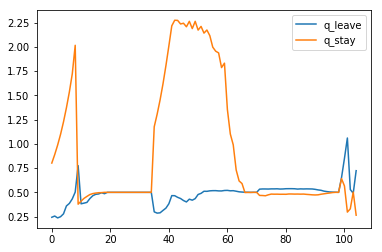

In [27]:
# get number of states
env_info = {"state representation structure": "regular", 
            "fundamental timestep": 0.2, 
            "gamma": 0.9, 
            "pursuit port total duration": 7, 
            "background port total duration": 7, 
            "transit duration": 0.5, 
            "consumption duration": 1, 
            "first time in pursuit port that could give a reward": 1.2,
            "required minimum wait time in pursuit port": 1.2, 
            "required minimum wait time in background port": 1, 
            "time to wait until the trial reset": 1.5, 
            "exponential distribution scale": 4, 
            "delivery time in the background port": 1.6,
            "reward amount in pursuit": 2.4, 
            "reward amount in background": [0.6, 1.8]}


env = GiveUpEnvironment(env_info=env_info)
num_states = env.num_states


# run experiment
MaxRuns = 5
leave_values = np.zeros([MaxRuns, num_states])
stay_values = np.zeros([MaxRuns, num_states])
for j in range(MaxRuns):
    
    seed = j+10
    env_info["seed"] = seed

    env = GiveUpEnvironment(env_info=env_info)
    num_states = env.num_states

    agent_info = {"num_actions": 2, 
                  "num_states": num_states, 
                  "epsilon": 0.05, 
                  "discount": 0.9, 
                  "step_size": 0.1, 
                  "seed": seed + 5000, 
                  "degree of exploration": 0.5, 
                  "exploration method": "UCB"}
    agent = QLearningAgent(agent_info=agent_info)
    #agent.agent_init(agent_info)
    #print(agent.policy)
    # agent_info.update({"policy": policy})

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(env_info, agent_info)
    rl_glue.rl_start(env_info, agent_info)
    values = rl_glue.agent.agent_message("get_action_values")
    MaxSteps = 500000
    TD_error = np.zeros(MaxSteps)
    prev_state = np.zeros(MaxSteps)
    current_state = np.zeros(MaxSteps)
    prev_action = np.zeros(MaxSteps)
    rewarded_bool = np.zeros(MaxSteps)

    for i in tqdm(range(MaxSteps)):
        prev_state[i] = rl_glue.agent.prev_state
        prev_action[i] = rl_glue.agent.prev_action
        roat = rl_glue.rl_step()
        rewarded_bool[i] = (roat[0] != 0)
        TD_error[i] = rl_glue.agent.agent_message("get TD error")
        current_state[i] = rl_glue.agent.prev_state
        

    values = rl_glue.agent.agent_message("get_action_values")
    leave_values[j] = values[:, 1]
    stay_values[j] = values[:, 0]
    
    prev_state = prev_state.astype(int)
    current_state = current_state.astype(int)
# fig, ax = plt.subplots(1, 1)
plot1 = plt.plot(np.mean(leave_values, axis=0), label = "q_leave")
plot2 = plt.plot(np.mean(stay_values, axis=0), label = "q_stay")
plt.legend(loc="upper right")
plt.show()

# FindExitIndex = np.where(values[80:120, 0] < values[80:120, 1])
# IndexArray = FindExitIndex[0] + 80
# BestExitIndex = min(IndexArray)
# print(BestExitIndex)
# print(env.state3d(BestExitIndex))


In [28]:
FindExitIndex = np.where(np.mean(stay_values[:, 60:120], axis=0) <= np.mean(leave_values[:, 60:120], axis=0))
IndexArray = FindExitIndex[0] + 60
BestExitIndex = min(IndexArray)
print(BestExitIndex)
print(env.state3d(BestExitIndex))

66
(1, 6.2, 0)


In [ ]:
# plot heatmap of TD errors aligned by reward time
first_PS_state = rl_glue.environment.state1d((1, 0, 0))
last_PS_time = rl_glue.environment.PSTimeArray[-1]
last_unrewarded_PS_state = rl_glue.environment.state1d((1, last_PS_time, 0))
first_rewarded_PS_state = last_unrewarded_PS_state + 1
last_rewarded_PS_state = rl_glue.environment.state1d((1, last_PS_time, 1))

rewarded_steps = np.nonzero(rewarded_bool)
rewarded_steps = rewarded_steps[0]
PS_rewarded_steps = []

for step in rewarded_steps: 
    if (prev_state[step] <= last_unrewarded_PS_state) and (prev_state[step] >= first_PS_state):
        PS_rewarded_steps.append(step)

PS_num_rewards = len(PS_rewarded_steps)
# data = np.zeros((PS_num_rewards, 50))
# data_states = np.zeros((PS_num_rewards, 50))

# for trial in range(PS_num_rewards): 
#     plot_range = np.arange(rewarded_steps[trial] - 25, rewarded_steps[trial] + 25)
#     data[trial, :] = TD_error[plot_range]
#     data_states[trial, :] = current_state[plot_range]




In [ ]:
PS_rewarded_time = np.zeros(PS_num_rewards)
PS_rewarded_TDerror = np.zeros(PS_num_rewards)
for trial in range(PS_num_rewards): 
    rewarded_state_1d = current_state[PS_rewarded_steps[trial]]
    rewarded_state_3d = rl_glue.environment.state3d(rewarded_state_1d)
    PS_rewarded_time[trial] = rewarded_state_3d[1]
    PS_rewarded_TDerror[trial] = TD_error[PS_rewarded_steps[trial]]



In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# colormap = ['#0091ad', '#d6f6eb', '#fdf1d2', '#faaaae', '#ff57bb'] # pink
# colormap = ['#0f3c4c', '#134b5f', '#165a72', '#1a6985', '#1e7898', '#2187ab', '#2596be'] #tinted blue
# colormap = ['#be8a25', '#ab7c21', '#986e1e', '#85611a', '#725316', '#5f4513', '#4c370f', '#39290b', '#261c07', '#130e04'] #tinted gold
colormap = ['#be8a25', '#d6f6eb', '#faaaae']

num_categories = len(colormap)
categories = np.ones(PS_num_rewards) * (num_categories - 1)
category_size = math.ceil((MaxSteps - 8000) / (num_categories - 1))

for trial in range(PS_num_rewards): 
    for c in range(num_categories - 1): 
        if (PS_rewarded_steps[trial] < category_size * (c+1)) and (PS_rewarded_steps[trial] >= category_size * c): 
            categories[trial] = c
            

categories = categories.astype(int)
category_color = []
for trial in range(PS_num_rewards): 
    category_color.append(colormap[categories[trial]])

fig, ax = plt.subplots(1,1)
ax.scatter(PS_rewarded_time, PS_rewarded_TDerror, c = category_color, alpha = 0.5)
ax.set_xlabel("Time to Reward at the Pursuit Port (sec)")
ax.set_ylabel("TD error")
ax.set_title("TD-dilating")
ax.set_xlim(1, 7)
# plt.savefig("TD errors from TD-dilating (3)")
plt.show()

In [ ]:
import seaborn as sns
ax = sns.heatmap(data, cmap="YlGnBu")
bx = sns.heatmap(data_states)
plt.show()

In [ ]:
first_PS_state = rl_glue.environment.state1d((1, 0, 0))
last_PS_time = rl_glue.environment.PSTimeArray[-1]
last_unrewarded_PS_state = rl_glue.environment.state1d((1, last_PS_time, 0))
first_rewarded_PS_state = last_unrewarded_PS_state + 1
last_rewarded_PS_state = rl_glue.environment.state1d((1, last_PS_time, 1))
PS_unrewarded_exit_bool = np.zeros(MaxSteps)

for i in range(MaxSteps): 
    if not (i >= MaxSteps - 1):
        if (prev_state[i] <= last_unrewarded_PS_state) and (prev_state[i] >= first_PS_state) and ((prev_state[i + 1] == 0) or (prev_state[i + 1] == first_PS_state)): 
            PS_unrewarded_exit_bool[i] = 1

        else: 
            pass

PS_unrewarded_exit = np.nonzero(PS_unrewarded_exit_bool) # indices of steps where the agent exits pursuit port unrewarded
exit_state_time = np.zeros(len(PS_unrewarded_exit[0]))
for i in range(len(PS_unrewarded_exit[0])): 
    exit_step = PS_unrewarded_exit[0][i]
    # print(exit_step)
    exit_state1d = prev_state[exit_step]
    exit_state1d = int(exit_state1d)
    # print(exit_state1d)
    exit_state3d = rl_glue.environment.state3d(exit_state1d)
    # print(exit_state3d)
    exit_state_time[i] = exit_state3d[1]

plt.plot(exit_state_time)
# len(PS_unrewarded_exit)


Plot action values in background port. 

In [ ]:

BGlen = len(rl_glue.environment.BGTimeArray)
xticklabel = np.zeros(BGlen)
print(BGlen)
average_leave_values = np.mean(leave_values, axis = 0)
average_stay_values = np.mean(stay_values, axis = 0)
for i in range(BGlen): 
    X = rl_glue.environment.state3d(i)
    xticklabel[i] = X[1]

fig, ax = plt.subplots(1, 1)
y0 = average_stay_values
y1 = average_leave_values
ax.plot(xticklabel, y0[0:BGlen], label = "Q_stay")
ax.plot(xticklabel, y1[0:BGlen], label = "Q_leave")
ax.legend(loc = "upper right")
ax.set_xticks(xticklabel)
ax.set_xticklabels(ax.get_xticks(), rotation = 60)
ax.set_xlabel('Time in Background port (sec)')
ax.set_title('Q(state-action pair)')
# ax.set_xticks(rl_glue.environment.BGTimeArray)
# ax.set_xticklabels(xticklabel)
ax.set_ylabel('Value')
plt.show()

Plot action values in pursuit port when the agent has not been rewarded. 

In [ ]:
PSlen = len(rl_glue.environment.PSTimeArray)
xticklabel = np.zeros(PSlen)

average_leave_values = np.mean(leave_values, axis = 0)
average_stay_values = np.mean(stay_values, axis = 0)
for i in range(PSlen): 
    X = rl_glue.environment.state3d(i + BGlen)
    xticklabel[i] = X[1]

fig, ax = plt.subplots(1, 1)
y0 = average_stay_values
y1 = average_leave_values
ax.plot(xticklabel, y0[BGlen:BGlen + PSlen], label = "Q_stay")
ax.plot(xticklabel, y1[BGlen:BGlen + PSlen], label = "Q_leave")
ax.legend(loc = "upper right")
ax.set_xticks(xticklabel)
ax.set_xticklabels(ax.get_xticks(), rotation = 60)
ax.set_xlabel('Time in Pursuit port (sec)')
ax.set_title('Q(state-action pair)')
# ax.set_xticks(rl_glue.environment.BGTimeArray)
# ax.set_xticklabels(xticklabel)
ax.set_ylabel('Value')
plt.show()

In [ ]:
length = len(average_stay_values)
merged = np.zeros((2, length))
merged[0] = average_stay_values
merged[1] = average_leave_values
merged[:, 0:20]

In [ ]:
from matplotlib import colors

BGlen = len(rl_glue.environment.BGTimeArray)

plotpart = range(0, BGlen)
xticklabel = np.zeros(BGlen)

average_leave_values = np.mean(leave_values, axis = 0)
average_stay_values = np.mean(stay_values, axis = 0)

action_values = np.zeros((2, length))
action_values[0] = average_stay_values
action_values[1] = average_leave_values

data = action_values[:, plotpart]

# create discrete colormap
cmap = colors.Colormap('Blues')
# cmap = colors.ListedColormap(['red', 'blue'])
# bounds = [0,10,20]
# norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=((1,0.1)))
plt.imshow(data, cmap=cmap)

# draw gridlines
# plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
# ax.set_xticks(np.arange(-.5, 10, 1));
# ax.set_yticks(np.arange(-.5, 10, 1));

plt.show()

In [ ]:
start = 499600
duration = 100
fig, bx = plt.subplots(1,1)
bx.plot(TD_error)
plt.xlim([start, start + duration])

fig, cx = plt.subplots(1,1)
cx.plot(prev_state)
plt.xlim([start, start + duration])

## Section 3. Policy Evaluation with Basic TD
Finally, see the TD policy evaluation algorithm in action by looking at the estimated values, the per state value error and after the experiment is complete, the Mean Squared Value Error curve vs. episode number, summarizing how the value error changed over time.

The code below runs one run of an experiment given env_info and agent_info dictionaries.

In [ ]:
env_info = {"state representation structure": "regular", 
            "fundamental timestep": 0.1, 
            "gamma": 0.95, 
            "pursuit port total duration": 7, 
            "background port total duration": 7, 
            "transit duration": 0.5, 
            "consumption duration": 1, 
            "first time in pursuit port that could give a reward": 1.2,
            "required minimum wait time in pursuit port": 1.2, 
            "required minimum wait time in background port": 1, 
            "time to wait until the trial reset": 1.5, 
            "exponential distribution scale": 4, 
            "delivery time in the background port": 1.6,
            "reward amount in pursuit": 3, 
            "reward amount in background": 0.3}
env = GiveUpEnvironment(env_info=env_info)
env.test_reward_function()
(rou_g, rou_l, t_rou_g, t_rou_l) = env.PolicyMax()
fig, ax = plt.subplots(1, 1)
ax.plot(env.PSTimeArray, rou_g)
ax.plot(env.PSTimeArray, rou_l)
print(f"According to the global reward rate, the optimal give-up time in the pursuit port is at {t_rou_g} second!")
print(f"According to the local reward rate, the optimal give-up time in the pursuit port is at {t_rou_l} second!")

In [ ]:
print(env.PSTimeArray)
print(env.TravelTimeArray)
print(env.PSMinDelay)
FindStateStart(env.PSTimeArray, env.PSMinDelay)

In [ ]:
def make_policy(ps_exit_time, env): 
    policy = np.ones(shape=(env.num_states, 2)) * 0.5
    for i in range(env.state1d((0, env.BGRewardTime, 0)) + 1):
        policy[i] = [1, 0]
    policy[env.state1d((0, env.BGRewardTime, 0)) + 1] = [0, 1]
    
    exit_state_time = FindStateStart(env.PSTimeArray, ps_exit_time)
    for i in range(env.state1d((1, 0, 0)), env.state1d((1, exit_state_time, 0))):
        policy[i] = [1, 0]
    policy[env.state1d((1, exit_state_time, 0))] = [0, 1]
    
    min_delay_state = FindStateStart(env.PSTimeArray, env.PSMinDelay)
    for i in range(env.state1d((1, min_delay_state, 1)), env.state1d((1, env.PSTimeArray[-1], 1)) + 1):
        policy[i] = [0, 1]
    policy[env.state1d((2, env.TravelTimeArray[-1], 0))] = [0, 1]
    policy[env.state1d((3, env.TravelTimeArray[-1], 0))] = [0, 1]
    return policy

# make_policy(1.6, env)

In [ ]:
def evaluate_policy_basic_TD(PS_exit_time, max_steps, state_rep_struct, seed): 
    from rl_glue import RLGlue
    from agent import BaseAgent
    from environment import BaseEnvironment  
    
    env_info = {"state representation structure": state_rep_struct, 
                "fundamental timestep": 0.1, 
                "gamma": 0.95, 
                "pursuit port total duration": 7, 
                "background port total duration": 7, 
                "transit duration": 0.5, 
                "consumption duration": 1, 
                "first time in pursuit port that could give a reward": 1.2,
                "required minimum wait time in pursuit port": 1.2, 
                "required minimum wait time in background port": 1, 
                "time to wait until the trial reset": 1.5, 
                "exponential distribution scale": 4, 
                "delivery time in the background port": 1.6,
                "reward amount in pursuit": 3, 
                "reward amount in background": 0.3}
    
    env = GiveUpEnvironment(env_info=env_info)
    
    MaxSteps = max_steps
    num_sessions = 5
    value_all_sessions = np.zeros((num_sessions, env.num_states))
    

    for j in tqdm(range(num_sessions)): 
        
        env_info["seed"] = seed + 7*j
        env = GiveUpEnvironment(env_info=env_info)

        # define policy
        policy = make_policy(PS_exit_time, env)


        agent_info = {"policy": policy, "discount": 0.95, "step_size": 0.1, "seed": seed + 500 + 6*j}
        agent = BasicTDAgent(agent_info=agent_info)
        #agent.agent_init(agent_info)
        #print(agent.policy)
        # agent_info.update({"policy": policy})
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(env_info, agent_info)
        rl_glue.rl_start(env_info, agent_info)
    
        TD_error = np.zeros(MaxSteps)
        state_of_last_step = np.zeros(MaxSteps)


        for i in range(MaxSteps):
            roat = rl_glue.rl_step()
    #         TD_error[i] = rl_glue.agent.agent_message("get TD error")
    #         state_of_last_step[i] = rl_glue.agent.last_state
        values = rl_glue.agent.agent_message("get_values")
        value_all_sessions[j,:] = values
    
    mean_value_across_session = np.mean(value_all_sessions, axis = 0)
    
    return mean_value_across_session

v_16 = evaluate_policy_basic_TD(1.6, 50000, "dilating", 5000)
v_24 = evaluate_policy_basic_TD(2.4, 50000, "dilating", 5001)
v_32 = evaluate_policy_basic_TD(3.2, 50000, "dilating", 5002)
v_40 = evaluate_policy_basic_TD(4.0, 50000, "dilating", 5003)
v_48 = evaluate_policy_basic_TD(4.8, 50000, "dilating", 5004)
v_56 = evaluate_policy_basic_TD(5.6, 50000, "dilating", 5005)
v_64 = evaluate_policy_basic_TD(6.4, 50000, "dilating", 5006)


In [ ]:
# Plot average state values under different policies
vm_16 = np.mean(v_16)
vm_24 = np.mean(v_24)
vm_32 = np.mean(v_32)
vm_40 = np.mean(v_40)
vm_48 = np.mean(v_48)
vm_56 = np.mean(v_56)
vm_64 = np.mean(v_64)
fig, ax = plt.subplots(1, 1)
policy_list = [1.6, 2.4, 3.2, 4.0, 4.8, 5.6, 6.4]
mean_state_value_dilating = [vm_16, vm_24, vm_32, vm_40, vm_48, vm_56, vm_64]
ax.scatter(policy_list, mean_state_value_regular, label = "regular")
ax.scatter(policy_list, mean_state_value_dilating, label = "dilating")
ax.set_xticks(policy_list)
ax.set_xticklabels(ax.get_xticks())
ax.legend(loc = "upper left")
ax.set_xlabel('Policy indicated by Exit Time (sec)')
ax.set_ylabel('Average State Values')
ax.set_ylim(0.19, 1.45)
plt.savefig("Average State Value Under Each Policy")
plt.show()

In [ ]:
print(mean_state_value_regular)

In [ ]:
# Plot all state values under different policies
BGlen = len(rl_glue.environment.BGTimeArray)
PSlen = len(rl_glue.environment.PSTimeArray)
xticklabel = np.zeros(PSlen)

for i in range(PSlen): 
    X = rl_glue.environment.state3d(i + BGlen)
    xticklabel[i] = X[1]


fig, ax = plt.subplots(1, 1)

ax.plot(xticklabel, v_16[BGlen:BGlen + PSlen], label = "T_exit = 1.6 s")
ax.plot(xticklabel, v_24[BGlen:BGlen + PSlen], label = "T_exit = 2.4 s")
ax.plot(xticklabel, v_32[BGlen:BGlen + PSlen], label = "T_exit = 3.2 s")
ax.plot(xticklabel, v_40[BGlen:BGlen + PSlen], label = "T_exit = 4.0 s")
ax.plot(xticklabel, v_48[BGlen:BGlen + PSlen], label = "T_exit = 4.8 s")
ax.plot(xticklabel, v_56[BGlen:BGlen + PSlen], label = "T_exit = 5.6 s")
ax.plot(xticklabel, v_64[BGlen:BGlen + PSlen], label = "T_exit = 6.4 s")
ax.legend(loc = "upper right")
ax.set_xticks(xticklabel)
ax.set_xticklabels(ax.get_xticks(), rotation = 60)
ax.set_xlabel('Time in Pursuit port (sec)')
ax.set_title('V(state)')
# ax.set_xticks(rl_glue.environment.BGTimeArray)
# ax.set_xticklabels(xticklabel)
ax.set_ylabel('Value')
ax.set_ylim(-0.2, 4.2)
plt.savefig("State Values under Different Policies - dilating")
plt.show()

In [ ]:
env_info = {"state representation structure": "dilating", 
            "fundamental timestep": 0.1, 
            "gamma": 0.95, 
            "pursuit port total duration": 7, 
            "background port total duration": 7, 
            "transit duration": 0.5, 
            "consumption duration": 1, 
            "first time in pursuit port that could give a reward": 1.2,
            "required minimum wait time in pursuit port": 1.2, 
            "required minimum wait time in background port": 1, 
            "time to wait until the trial reset": 1.5, 
            "exponential distribution scale": 4, 
            "delivery time in the background port": 1.6,
            "reward amount in pursuit": 3, 
            "reward amount in background": 1.5}

env = GiveUpEnvironment(env_info=env_info)
#env.env_init(env_info)

# The Optimal Policy that maximizes the global reward rate
num_states = env.num_states
(rou_g, rou_l, t_rou_g, t_rou_l) = env.PolicyMax()
OptimalExit = t_rou_g

policy = make_policy(OptimalExit, env)


agent_info = {"policy": policy, "discount": 0.95, "step_size": 0.1, "seed": 0}
agent = BasicTDAgent(agent_info=agent_info)
#agent.agent_init(agent_info)
#print(agent.policy)
# agent_info.update({"policy": policy})
rl_glue = RLGlue(env, agent)
rl_glue.rl_init(env_info, agent_info)
rl_glue.rl_start(env_info, agent_info)
values = rl_glue.agent.agent_message("get_values")

# MaxSteps = 500000
# TD_error = np.zeros(MaxSteps)
# state_of_last_step = np.zeros(MaxSteps)

# for i in tqdm(range(MaxSteps)):
#     roat = rl_glue.rl_step()
#     TD_error[i] = rl_glue.agent.agent_message("get TD error")
#     state_of_last_step[i] = rl_glue.agent.last_state
# #     print(roat)
# #     print(TD_error[i])
# #     if (i > MaxSteps * 0.75):
# #         values = rl_glue.agent.agent_message("get_values")
# #         ax.plot(values, str(0.9 * (1 - i / MaxSteps)))
# values = rl_glue.agent.agent_message("get_values")


In [ ]:
start = 45
duration = 25
fig, bx = plt.subplots(1,1)
bx.plot(TD_error)
plt.xlim([start, start + duration])

fig, cx = plt.subplots(1,1)
cx.plot(state_of_last_step)
plt.xlim([start, start + duration])


In [ ]:
x = agent_info["policy"]
x.shape
y = np.array([[1.], [1.]])
z = y[1]
z[0]
agent_info.get("policy")
agent = BasicTDAgent()
agent.agent_init(agent_info)
print(agent.policy)
print(agent.values)
print(agent.policy.shape[0])


In [ ]:
%matplotlib notebook

# ---------------
# Discussion Cell
# ---------------

def run_experiment(env_info, agent_info,num_episodes=5000, experiment_name=None, plot_freq=100, true_values_file=None, value_error_threshold=1e-8):
    env = CliffWalkEnvironment
    agent = TDAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info, env_info)

    manager = Manager(env_info, agent_info, true_values_file=true_values_file, experiment_name=experiment_name)
    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")
            manager.visualize(values, episode)

    values = rl_glue.agent.agent_message("get_values")
    return values

In [ ]:
def measure_convergence(ExplorationStrategy, ExplorationConstant, StepSize): 
    # get number of states
    env_info = {"state representation structure": "dilating", 
                "fundamental timestep": 0.2, 
                "gamma": 0.95, 
                "pursuit port total duration": 7, 
                "background port total duration": 9, 
                "transit duration": 0.5, 
                "consumption duration": 1, 
                "first time in pursuit port that could give a reward": 1.2,
                "required minimum wait time in pursuit port": 1.2, 
                "time to wait until the trial reset": 1.5, 
                "exponential distribution scale": 4, 
                "delivery time in the background port": 5,
                "required minimum wait time in background port": 5,
                "reward amount in pursuit": 3, 
                "reward amount in background": 0.6}
    env = GiveUpEnvironment(env_info=env_info)
    num_states = env.num_states


    # run experiment
    MaxRuns = 1
    leave_values = np.zeros([MaxRuns, num_states])
    stay_values = np.zeros([MaxRuns, num_states])
    for j in range(MaxRuns):
        
        env_info["seed"] = j

        env = GiveUpEnvironment(env_info=env_info)
        num_states = env.num_states

        agent_info = {"num_actions": 2, 
                      "num_states": num_states, 
                      "epsilon": ExplorationConstant, 
                      "discount": 0.95, 
                      "step_size": StepSize, 
                      "seed": j, 
                      "degree of exploration": ExplorationConstant, 
                      "exploration method": ExplorationStrategy}
        agent = QLearningAgent(agent_info=agent_info)
        #agent.agent_init(agent_info)
        #print(agent.policy)
        # agent_info.update({"policy": policy})

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(env_info, agent_info)
        rl_glue.rl_start(env_info, agent_info)
        values = rl_glue.agent.agent_message("get_action_values")
        MaxSteps = 500000
        TD_error = np.zeros(MaxSteps)
        prev_state = np.zeros(MaxSteps)
        prev_action = np.zeros(MaxSteps)
        average_reward = np.zeros(MaxSteps)

        for i in tqdm(range(MaxSteps)):
            roat = rl_glue.rl_step()
#             TD_error[i] = rl_glue.agent.agent_message("get TD error")
#             prev_state[i] = int(rl_glue.agent.prev_state)
#             prev_action[i] = rl_glue.agent.prev_action
            if (i != 0):
                average_reward[i] = rl_glue.total_reward / i
        
        return average_reward

plt.plot(measure_convergence("UCB", 0.3, 0.1), label = "UCB, C=0.3, alpha=0.1")
plt.plot(measure_convergence("UCB", 0.5, 0.1), label = "UCB, C=0.5, alpha=0.1")        
plt.plot(measure_convergence("UCB", 0.8, 0.1), label = "UCB, C=0.8, alpha=0.1")
plt.plot(measure_convergence("UCB", 0.3, 0.5), label = "UCB, C=0.3, alpha=0.5")



plt.legend(loc="lower right")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Performance of UCB on different parameters")
plt.savefig('narrowed_UCB_parameter_study.png')
plt.show()
